# Load raw X-mode burst swept reflectometry data

In [1]:
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import skreflectometry
# from skreflectometry import data
%matplotlib inline

In [2]:
# Loading data
data = skreflectometry.data.raw_xmode_both_cutoff_burst()
frequency = data['frequency']
signals = data['signal']
signal = data['signal'][0]
dfdt = data['dfdt']
fs = data['sampling_frequency']


In [3]:
print(signals)
signals[0]==signals[1]

[[  5.26079752e-02-0.01795704j  -4.49099139e-03-0.12459927j
   -6.66541270e-02-0.19624708j ...,  -5.85077529e-03-0.00145566j
   -4.41407024e-03-0.00117472j  -2.69715138e-03-0.00100507j]
 [  2.67683290e-02-0.01800548j   2.24880681e-02+0.0860175j
    3.48688486e-02+0.16317118j ...,  -6.15048285e-03-0.00339837j
   -6.02506797e-03-0.00297075j  -5.83803144e-03-0.00250397j]
 [ -4.72428786e-02-0.00887513j  -9.10058640e-02-0.02896989j
   -1.25193139e-01-0.03150018j ...,  -7.30448908e-03+0.00580617j
   -4.97761860e-03+0.00538595j  -2.17286708e-03+0.00502448j]
 ..., 
 [  3.45021994e-02-0.00757234j   5.28297610e-02-0.10393516j
    4.80246405e-02-0.17967585j ...,  -2.69735135e-03+0.00145903j
   -1.73827488e-03+0.00220406j  -5.83094046e-04+0.00323244j]
 [  4.68536065e-02+0.01786022j   4.00961798e-02-0.05509573j
    1.90876430e-02-0.11295152j ...,  -2.33295152e-03+0.00599941j
   -6.37682905e-04+0.00623358j   1.18382991e-03+0.00645875j]
 [ -1.09086461e-04+0.03536913j   6.90976262e-02-0.10377442j
    

array([False, False, False, ..., False, False, False], dtype=bool)

## Plotting the raw data

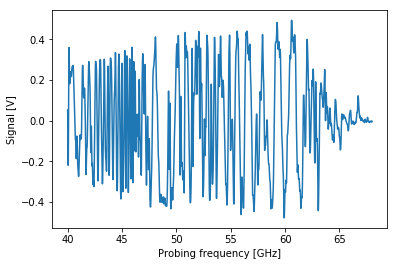

In [4]:

plt.plot(frequency*1e-9, signal.real, label='Real')
plt.xlabel('Probing frequency [GHz]')
plt.ylabel('Signal [V]')


## Plotting the spectrogram data

(0.052607975197-0.0179570416517j)
(0.0267683290234-0.0180054847746j)
(-0.0472428785804-0.00887512833494j)
(0.0576170302531-0.0198852524473j)
(0.045693900576-0.0216748127561j)
(0.0183358118415-0.0403451009871j)
(0.0358712247181-0.0280193924747j)
(0.0345021994165-0.00757233505846j)
(0.0468536064967+0.0178602235364j)
(-0.000109086461044+0.0353691289546j)


(0, 10)

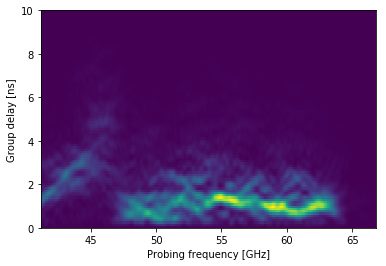

In [5]:
PERSIST = skreflectometry.SWEEP_PERSISTENCE(4)

for signal in signals:
    
    print(signal[0])
    probing_frequency, beat_frequency, power = skreflectometry.sweep_spectrum(frequency, signal, fs,
                                                          nperseg=256,noverlap=250,nfft=1024)
    
    power = PERSIST(power)
    group_delay = skreflectometry.sweep_delay(beat_frequency,dfdt)

plt.pcolormesh(probing_frequency*1e-9, group_delay*1e9, power)
plt.xlabel('Probing frequency [GHz]')
plt.ylabel('Group delay [ns]')
plt.ylim(0,10)

## X-mode reflectometry with both upper and lower cutoff reflections

In [5]:
# Loading data
data = skreflectometry.data.raw_xmode_both_cutoff()
frequency = data['frequency']
signal = data['signal']
dfdt = data['dfdt']
fs = data['sampling_frequency']


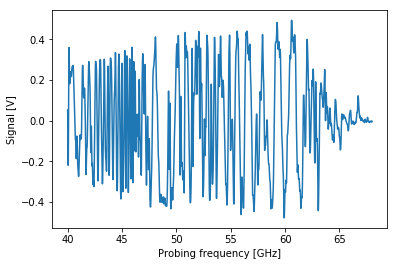

In [6]:

plt.plot(frequency*1e-9, signal.real, label='Real')
plt.xlabel('Probing frequency [GHz]')
plt.ylabel('Signal [V]')


(0, 10)

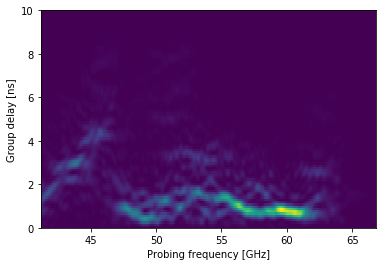

In [7]:
probing_frequency, beat_frequency, power = skreflectometry.sweep_spectrum(frequency, signal, fs,
                                                      nperseg=256,noverlap=250,nfft=1024)
group_delay = skreflectometry.sweep_delay(beat_frequency,dfdt)

plt.pcolormesh(probing_frequency*1e-9, group_delay*1e9, power)
plt.xlabel('Probing frequency [GHz]')
plt.ylabel('Group delay [ns]')
plt.ylim(0,10)

In [111]:
import numpy as np

class SWEEP_PERSISTENCE(object):
    """ 
    Contains the clas object that handles the STFT persistence algorithm
    The persistence is initialized with a given number of accumulations nracums.
    It internally stores an array of matrices that correspond to the size of the
    calculated STFT matrix.
    
    Parameters
    ----------
    persistence : int
        Number of sweeps to persist
    spectrum : 2d array
        2D spectrum to persist
        
    Returns
    -------
    persisted_spectrum : 2d array
        2D array of the persisted spectrum
    """
    
    def __init__(self, persistence=4, func=np.sum):
        self.persistence = persistence
        
        self.func = func
        
        self.persisted_spectrum = None
        self.__persist_iter = 0
        self.__persist_Nwindow = self.persistence
        
        self.__persist_mem_spectrum = None
    
    def __allocMemSTFT(self,stft_shape):
        # Creates aux matrices in memory for persistence window
        self.__persist_mem_spectrum = np.zeros(np.append([self.__persist_Nwindow],np.array([stft_shape])))

    def doPersist(self, func=None, memidx=None):
        """
        Calculates persistence over the given range with func
        """
        memidx = memidx or range(len(self.__persist_mem_spectrum))
        func = func or self.func
        persisted_spectrum = func(self.__persist_mem_spectrum[memidx], axis=0)
        return persisted_spectrum

    def reset(self, **kwargs):
        
        self.__init__(**kwargs)
    def __call__(self, spectrum, func=None,**kwargs):
        if self.__persist_mem_spectrum is None:
            self.__allocMemSTFT(spectrum.shape)
            self.__persist_iter = 0
        
        func = func or self.func

        # Adds current stft to memory of persistence stft
        self.__persist_mem_spectrum[self.__persist_iter] = spectrum
            
        self.persisted_spectrum = self.doPersist(func)

            
        self.__persist_iter = (self.__persist_iter +1)% self.__persist_Nwindow
        
        return self.persisted_spectrum


In [112]:
PERSIST = SWEEP_PERSISTENCE(2)

In [214]:
# a = np.random.rand(4,4)
b = PERSIST(b-1,np.mean)
a,b

(array([[ 0.85937407,  0.29265366,  0.26676232,  0.10248986],
        [ 0.7316955 ,  0.54689514,  0.93994756,  0.85461438],
        [ 0.54474346,  0.68404896,  0.08793497,  0.28360991],
        [ 0.99829639,  0.34649478,  0.08258394,  0.56597172]]),
 array([[-44.02951482, -44.59623523, -44.62212657, -44.78639903],
        [-44.15719339, -44.34199375, -43.94894133, -44.03427451],
        [-44.34414542, -44.20483993, -44.80095392, -44.60527898],
        [-43.8905925 , -44.54239411, -44.80630495, -44.32291717]]))

In [197]:
PERSIST.reset(persistence=1)

In [71]:
a,b

(array([[ 0.22376392,  0.74921466,  0.67056584,  0.46909364],
        [ 0.02313822,  0.38475175,  0.36380303,  0.0269852 ],
        [ 0.29079471,  0.51618662,  0.19444236,  0.72711273],
        [ 0.73513888,  0.26975337,  0.20660904,  0.81691151]]),
 array([[ 0.22376392,  0.74921466,  0.67056584,  0.46909364],
        [ 0.02313822,  0.38475175,  0.36380303,  0.0269852 ],
        [ 0.29079471,  0.51618662,  0.19444236,  0.72711273],
        [ 0.73513888,  0.26975337,  0.20660904,  0.81691151]]))